# Image Classification using a convolutional neural network

In [1]:
# Uncomment and run the commands below if imports fail
# !conda install numpy pytorch torchvision cpuonly -c pytorch -y
# !pip install matplotlib --upgrade --quiet
!pip install jovian --upgrade --quiet

In [2]:
# Imports
import os
import numpy as np
import torch
import jovian
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset
import torchvision
from torchvision.utils import make_grid
import torchvision.transforms as tt
from torchvision.datasets import CIFAR10, ImageFolder
from torchvision.datasets.utils import download_url
~
import tarfile

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'
%matplotlib inline

%config Completer.use_jedi = False

<IPython.core.display.Javascript object>

In [3]:
project_name='CNN-template'

## Download Dataset

In [4]:
# download dataset from torch repo (will be shuffled)
dataset = CIFAR10(root='data/', train=True, download=True, transform=tt.ToTensor())

dataset_test = CIFAR10(root='data/', train=False, download=True, transform=tt.ToTensor())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [9]:
# alternatively download dataset from url
ds_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(ds_url, '.')

In [9]:
# Extract from archive save to folder
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data_url')

  0%|          | 0/135107811 [00:00<?, ?it/s]

In [10]:
# define a list of classes from dir structure (1 folder per class)
data_url_dir = './data_url/cifar10'
os.listdir(data_url_dir)
classes_url = os.listdir(data_url_dir + '/train')
print(classes_url)

['bird', 'deer', 'cat', 'dog', 'frog', 'truck', 'ship', 'horse', 'airplane', 'automobile']


In [11]:
# look into folder
airplane_files = os.listdir(data_url_dir + '/train/airplane')
print('N images in folder:', len(airplane_files))
print(airplane_files[0:5])

N images in folder: 5000
['4504.png', '2599.png', '3288.png', '0560.png', '4674.png']


## Prepare dataset

In [14]:
# calculate sample mean and std deviation
ds = ImageFolder(data_url_dir+'/train', transform=tt.ToTensor())

dl = DataLoader(ds, batch_size=50000)

for i,j in dl:
    ds_mean = i.permute(1,0,2,3).mean(dim=(1,2,3))
    ds_std = i.permute(1,0,2,3).std(dim=(1,2,3))
    print(i.shape, j.shape)
    print(ds_std)
    print(ds_mean)
    break

torch.Size([50000, 3, 32, 32]) torch.Size([50000])
tensor([0.2470, 0.2435, 0.2616])
tensor([0.4914, 0.4822, 0.4465])


In [15]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
train_trf = tt.Compose([   tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                           tt.RandomHorizontalFlip(), 
                         # tt.RandomRotation(degrees=90),
                         # tt.RandomResizedCrop(32, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                           tt.ToTensor(),
                           tt.Normalize(*stats,inplace=True)
                        ])
val_test_trf = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [16]:
# split in training and validation datasets with different transformations
# define pytorch datasets from folder (won't be shuffled), and transform
dataset_url_traintf = ImageFolder(data_url_dir+'/train',
                          transform=train_trf)
dataset_url_valtf = ImageFolder(data_url_dir+'/train',
                          transform=val_test_trf)
dataset_url_test = ImageFolder(data_url_dir+'/test',
                          transform=val_test_trf)

In [17]:
# generate indices of training and validation datasets
idx = list(range(len(dataset_url_traintf)))
np.random.shuffle(idx)
idx_train = idx[:40000]
idx_val = idx[40000:]

# define training and validation datasets
dataset_url_train = Subset(dataset_url_traintf, idx_train)
dataset_url_val = Subset(dataset_url_valtf, idx_val)

In [18]:
# sample object types (tuple of tensor and int), sizes and ds classes
img, label = dataset_url_train[5000]
print('Object types:', type(img), type(label))
print('Sizes:', img.shape, label)
print('Dataset slasses:', dataset_url_traintf.classes)

Object types: <class 'torch.Tensor'> <class 'int'>
Sizes: torch.Size([3, 32, 32]) 0
Dataset slasses: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [19]:
# show one sample
def show_sample(data):
    ''' in: tuple(torch.tensor, int)
        out: sample label and image
    '''
    img, lbl = data
    plt.imshow(img.permute(1,2,0))
    print('Label:', dataset.classes[lbl], '('+str(lbl)+')')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: dog (5)


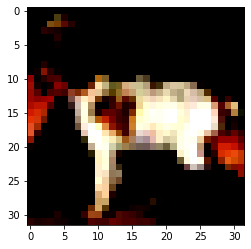

In [20]:
show_sample(dataset_url_test[5000])

## Training and validation datasets

In [16]:
# split in training and validation datasets with same transformation
# set ds parameters
val_size = 5000
train_size = len(dataset) - val_size
seed = 42
batch_size = 100

# split in train and val datasets at fixed random seed
train_ds, val_ds = random_split(dataset, [train_size, val_size],
                               generator=torch.Generator().manual_seed(seed))

# define loader objects
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(dataset_test, batch_size, shuffle=True, num_workers=4, pin_memory=True)

In [21]:
# define loader objects for training and validation datasets with different transformations
batch_size = 100

train_loader = DataLoader(dataset_url_train,
                          batch_size,
                          shuffle=True,
                          num_workers=4,
                          pin_memory=True)
val_loader = DataLoader(dataset_url_val,
                          batch_size,
                          shuffle=True,
                          num_workers=4,
                          pin_memory=True)
test_loader = DataLoader(dataset_url_test,
                          batch_size,
                          shuffle=True,
                          num_workers=4,
                          pin_memory=True)


In [22]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for imgs, lbls in dl:
        plt.figure(figsize=(15, 15))
        plt.axis('off')
        denorm_images = denormalize(imgs, *stats)
        plt.imshow(make_grid(denorm_images[:64], nrow=8).permute(1,2,0))
        break

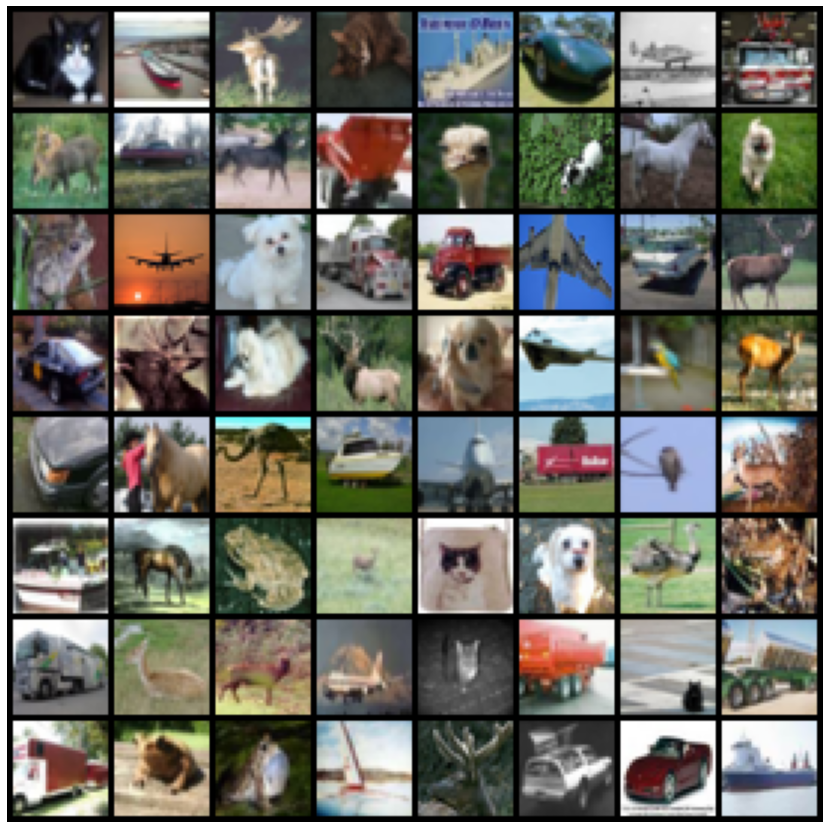

In [23]:
show_batch(val_loader)

## Models

In [54]:
# define a network base class with methods common to most networks
class Network_base(nn.Module):    
    
    # pass forward training data, record loss
    def training_step(self, batch):
        inpt, target = batch                     # split in&out per batch
        out = self(inpt)                         # call self.forward, generate predictions
        loss = F.cross_entropy(out, target)      # calculate loss
        return loss
    
    # pass forward validation data, record metrics
    def validation_batch(self, batch):         
        inpt, target = batch                     # split per batch input, target
        out = self(inpt)                         # generate predictions
        loss = F.cross_entropy(out, target)      # calculate batch loss
        accu = self.accuracy(out, target)        # calculate accuracy
        return {'val_loss' : loss.detach(),          # return dict()
                'accuracy' : accu.detach()}
    
    def validation_epoch(self, result):
        losses_batch = [r['val_loss'] for r in result]      # extract values from dict()
        accu_batch = [r['accuracy'] for r in result]    
        loss_epoch = torch.stack(losses_batch).mean()   # calulate epoch mean
        accu_epoch = torch.stack(accu_batch).mean()
        return {'val_loss' : loss_epoch.item(), 'accuracy' : accu_epoch.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], Last learning rate: {:,.5f}, Training loss: {:.4f}, Validation loss: {:.4f}, Accuracy: {:.4f}".format(
               epoch,
               result['lrs'],
               result['train_loss'],
               result['val_loss'],
               result['accuracy']))
        
    def accuracy(self, output, target):
        _, preds = torch.max(output, dim=1)    # output max value index
        acc = torch.tensor(torch.sum(preds == target).item()/len(preds)) #calc accuracy
        return acc
    
    def evaluate(self, val_loader):
        result = [self.validation_batch(batch)  # calulate batch mean l&a
                   for batch in val_loader]       # iterate over batches
        return self.validation_epoch(result)    # calculate epoch mean loss&accuray 

In [55]:
# define a CNN model with a specific architecture using network base
class CNN_Model(Network_base):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 32 x 16 x 16 (channel x image size)
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),  # input: 2048, output: 1024
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
    
    def forward(self, xb):
        return self.network(xb)

In [56]:
# model instance
model = CNN_Model()

In [57]:
# CNN testrun
for imgs, lbls in train_loader:
    print(imgs.shape)
    out = model(imgs)
    print(out.shape)
    break

torch.Size([100, 3, 32, 32])


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
# define a network with a residual architecture
class ResNet9(Network_base):
    def __init__(self, in_channels, n_classes):
        super().__init__()
        
        self.conv1 = self.conv_block(in_channels, 64)         # 3 x 32 x 32 -> 64 x 32 x 32
        self.conv2 = self.conv_block(64, 128, pool=True)      # -> 128 x 16 x 16
        
        self.res1 = nn.Sequential(self.conv_block(128, 128), self.conv_block(128, 128))
        
        self.conv3 = self.conv_block(128, 256, pool=True)     # -> 256 x 8 x 8
        self.conv4 = self.conv_block(256, 512, pool=True)     # -> 512 4 x 4
        
        self.res2 = nn.Sequential(self.conv_block(512, 512), self.conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), # -> 512 x 1 x 1
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, n_classes))
        
    def conv_block(self, in_channels, out_channels, pool=False):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                  nn.BatchNorm2d(out_channels),
                  nn.ReLU(inplace=True)]
        if pool: layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)
    
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out        # sum x and residual
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out        # sum x and residual
        out = self.classifier(out)
        return out

In [58]:
model_resnet = ResNet9(3, 10)

## Transfer data & model to GPU

In [59]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

# move data to GPU memory
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# load data batchwise to GPU if called
class DeviceDataLoader():
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
        
    def __iter__(self):
        for batch in self.dataloader:
            yield to_device(batch, self.device)
            
    def __len__(self):
        return len(self.dataloader)

In [60]:
# set default device to GPU if applicable
device = get_default_device()
device

device(type='cuda')

## Training

In [61]:
# fit the model
def fit(epochs, learning_rate, model, train_loader, val_loader, opt_funct=torch.optim.SGD):
    optimizer=opt_funct(model.parameters(), learning_rate)
    history = []                                 
    
    for epoch in range(epochs):                  # iterate n_epochs
        train_losses = []                        # record training losses
        for batch in train_loader:               # iterate over batches
            loss = model.training_step(batch)    # generate predictions # Calculate loss
            train_losses.append(loss)            # record training loss
            loss.backward()                      # compute gradients
            optimizer.step()                     # update weights
            optimizer.zero_grad()                # reset gradients
            
        result = model.evaluate(val_loader)     # compute validation l&a
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = learning_rate
        model.epoch_end(epoch, result)          # print epoch l&a
        history.append(result)                  # log epoch l&a to list
    return history

In [62]:
# transfer data to GPU
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

# transfer model to GPU
to_device(model, device)

# check
for batch in train_loader:
    img, lbl = batch
    print(img.device)
    break

cuda:0


In [63]:
# model pre training performance
history = [model.evaluate(val_loader)]
print(history)

[{'val_loss': 2.3028464317321777, 'accuracy': 0.10600000619888306}]


In [64]:
# set hyperparameters
learning_rate = 1.0e-3
epochs = 10

# set optimisation function
opt_function = torch.optim.Adam

In [65]:
# Train and record history
history += fit(epochs, learning_rate, model, train_loader, val_loader,
               opt_funct=opt_function)

Epoch [0], Last learning rate: 0.00100, Training loss: 1.7885, Validation loss: 1.4263, Accuracy: 0.4716
Epoch [1], Last learning rate: 0.00100, Training loss: 1.3118, Validation loss: 1.1176, Accuracy: 0.5922
Epoch [2], Last learning rate: 0.00100, Training loss: 1.0672, Validation loss: 0.8861, Accuracy: 0.6818
Epoch [3], Last learning rate: 0.00100, Training loss: 0.9232, Validation loss: 0.7862, Accuracy: 0.7188
Epoch [4], Last learning rate: 0.00100, Training loss: 0.8094, Validation loss: 0.7122, Accuracy: 0.7498
Epoch [5], Last learning rate: 0.00100, Training loss: 0.7315, Validation loss: 0.7167, Accuracy: 0.7505
Epoch [6], Last learning rate: 0.00100, Training loss: 0.6753, Validation loss: 0.6845, Accuracy: 0.7620
Epoch [7], Last learning rate: 0.00100, Training loss: 0.6234, Validation loss: 0.6130, Accuracy: 0.7910
Epoch [8], Last learning rate: 0.00100, Training loss: 0.5873, Validation loss: 0.5838, Accuracy: 0.7984
Epoch [9], Last learning rate: 0.00100, Training loss: 

In [68]:
# plot metrics
def plot_metrics(history):
    accuracies = [h['accuracy'] for h in history]
    train_losses = [h['train_loss'] for h in history[1:]]
    val_losses = [h['val_loss'] for h in history]

    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.plot(accuracies, '-x')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.subplot(122)
    plt.plot(range(1, len(train_losses)+1, 1),
             train_losses, '-rx',label='training')
    plt.plot(val_losses, '-bx', label='validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.suptitle('Accuracy and loss vs. No of epochs')
    plt.legend()
    plt.show()

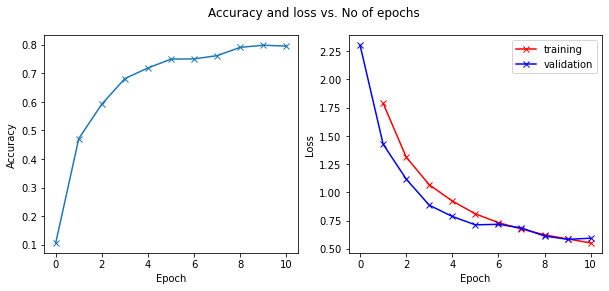

In [69]:
plot_metrics(history)

In [71]:
# test dataset l&a
performance = model.evaluate(test_loader)
print(performance['accuracy'])

0.7975000143051147


## Prediction

In [72]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: airplane , Predicted: airplane


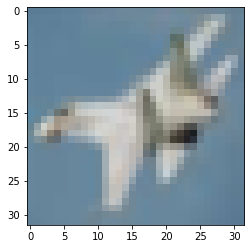

In [73]:
n=10
img, label = dataset_test[n]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', dataset.classes[predict_image(img, model)])

## Learning from the model

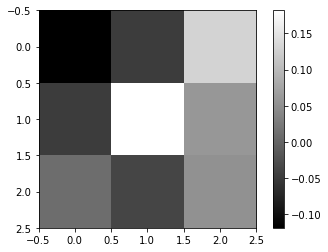

In [74]:
# plot a single kernel
kernel = model.network[0].weight.view(-1, 3, 3)[95].detach().cpu()
plt.imshow(kernel, cmap='gray')
plt.colorbar()
plt.show()

In [75]:
# define a truncated model using the learned prms yielding intermediary output
class layer(nn.Module):
    def __init__(self):
        super(layer, self).__init__()
        self.network = nn.Sequential(
            *list(model.network.children())[:17]
        )
    def forward(self, xb):
        out = self.network(xb)
        return out

In [76]:
model2 = to_device(layer(), device)

In [77]:
model2.parameters

<bound method Module.parameters of layer(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
  )
)>

In [78]:
# get intermediary output & labels
out = []
lbls = []
for batch in val_loader:
    xb, labels = batch
    yb = model2(xb)
    out.append(yb.detach().cpu())
    lbls.append(labels.cpu())
    
out = torch.stack(out)
lbls = torch.stack(lbls)

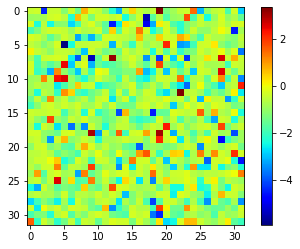

In [79]:
# plot intermed. output
img_inter = out.reshape(-1, 1024)[6]

plt.imshow(img_inter.reshape(32, 32), cmap='jet')
plt.colorbar()
plt.show()

In [80]:
# pca on intermed output
from sklearn import manifold, decomposition

In [81]:
data_inter = out.reshape(-1, 1024)[0:1000].numpy()
data_lbls = lbls.reshape(-1).numpy()[0:1000]

In [82]:
pca = decomposition.PCA(n_components=2)
data_pca = pca.fit_transform(data_inter)

In [84]:
# prepare data for tsne and umap
pca = decomposition.PCA(n_components=50)
data_red = pca.fit_transform(data_inter)

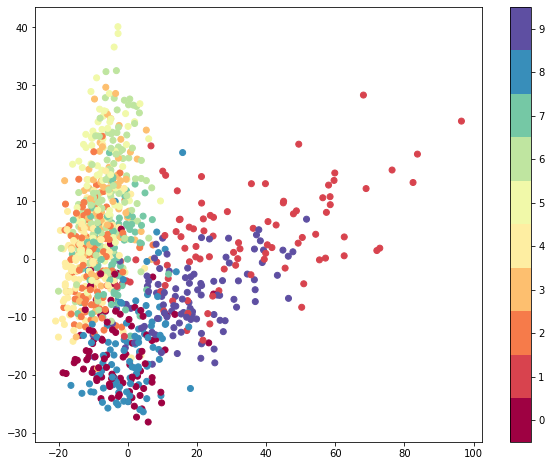

In [85]:
plt.figure(figsize=(10,8))
plt.scatter(data_red[:, 0], data_pca[:, 1], c=data_lbls, cmap=plt.cm.get_cmap('Spectral', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

In [86]:
# tsne on intermed putput
tsne = manifold.TSNE(n_components=2, init='pca', random_state=42)
Y_tsne = tsne.fit_transform(data_red)

In [87]:
Y_tsne[0]

array([-16.228994,  -4.099404], dtype=float32)

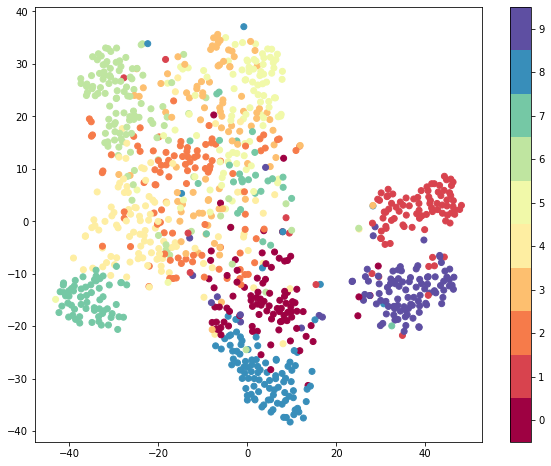

In [88]:
plt.figure(figsize=(10,8))
plt.scatter(Y_tsne[:, 0], Y_tsne[:, 1], c=data_lbls, cmap=plt.cm.get_cmap('Spectral', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

In [89]:
# umap on intermediary output
import umap

In [90]:
umap_red = umap.UMAP(n_components=2, init='spectral',random_state=42)
Y_umap = umap_red.fit_transform(data_red)

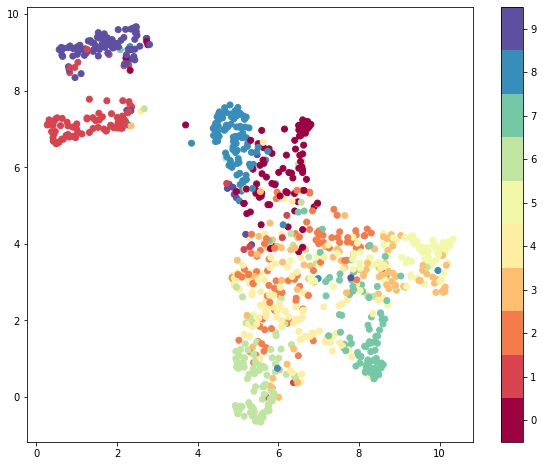

In [91]:
plt.figure(figsize=(10,8))
plt.scatter(Y_umap[:, 0], Y_umap[:, 1], c=lbls.reshape(-1).numpy()[0:1000], cmap=plt.cm.get_cmap('Spectral', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

## Saving and loading the model

In [92]:
# save current model parameters
torch.save(model.state_dict(), 'CIFAR10-cnn.pth')

In [93]:
# load model parameters
model2 = CIFAR10CnnModel()
model2.load_state_dict(torch.load('CIFAR10-cnn.pth'))

NameError: name 'CIFAR10CnnModel' is not defined

## Uploading notebook and saving metrics

In [37]:
jovian.commit(project=project_name, environment='auto', outputs=['CIFAR10-cnn.pth'])
jovian.commit(project=project_name, environment='auto', outputs=['CIFAR10-cnn.pth']) # Kaggle commit fails sometimes, so try again..

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ai/fmmoliere/CNN-template


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ai/fmmoliere/CNN-template


<IPython.core.display.Javascript object>

In [ ]:
architecture='afsdfasd'
jovian.log_hyperparams(architecture=architecture,
                       batch_size=batch_size,
                       learning_rate=learning_rate,
                       epochs=epochs,
                       optimizer=str(opt_function))

In [ ]:
jovian.log_metrics(training_loss=history[-1]['train_loss'],
                   validation_loss=history[-1]['Loss'],
                   test_loss=performance['Loss'],
                   validation_accuracy=history[-1]['Accuracy'],
                   test_accuracy=performance['Accuracy'])